In [3]:
import numpy as np
import scipy
import cv2
from matplotlib import pyplot as plt
from admm import ADMMTVSolver

## Some PSFs

In [4]:
def get_gaussian_psf(k_size, std):
    gaussian_1d = scipy.signal.windows.gaussian(k_size, std).reshape(k_size, 1)
    gaussian_kernel = gaussian_1d @ gaussian_1d.T
    gaussian_kernel /= np.sum(gaussian_kernel)

    return gaussian_kernel

def get_box_psf(k_size):
    return np.ones((k_size, k_size))/ (k_size**2)

def get_circle_psf(k_size):
    radius = k_size//2
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x*x + y*y <= radius*radius
    circle = np.zeros((k_size, k_size))
    circle[mask] = 1.0
    return circle / np.sum(circle)

## get a blurry image

In [17]:
from skimage.data import camera, astronaut

img = camera() / 255.0
k_size=9

psf = get_gaussian_psf(k_size, std=1.5)
# psf = get_box_psf(k_size)
# psf = get_circle_psf(k_size)

blurry_img = scipy.signal.convolve2d(img, psf, mode='same')
noise = 0.04 * np.random.randn(img.shape[0], img.shape[1])
blurry_noisy = np.clip(blurry_img + noise, 0, 1)

## Experiment with different λ's

100%|██████████| 30/30 [00:01<00:00, 21.20it/s]


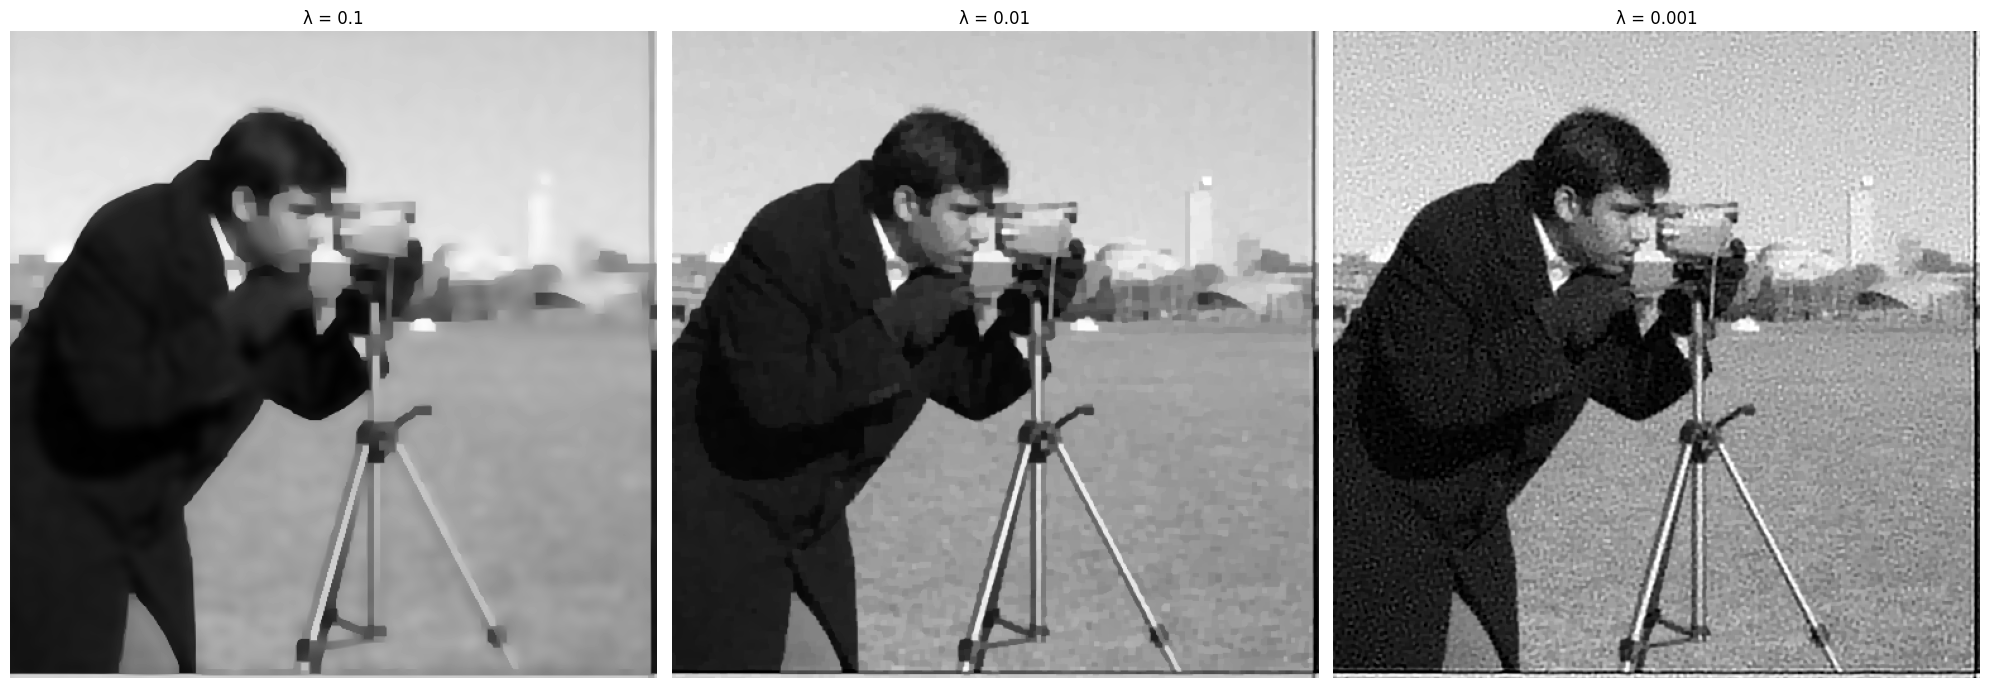

In [19]:
lmdas = [0.1, 0.01, 0.001]
n_iters = 50

rho = 0.2 # 0.1, 0.5 work decently
xs = []
for lmda in lmdas:
    DeconvSolver = ADMMTVSolver(blurry_noisy, psf, lmda, rho, log=True)
    n_iters = 30
    x = DeconvSolver.solve(n_iters)
    xs.append(x)

H, W = img.shape
plt.figure(figsize=(20, int(20*H/W)))

plt.subplot(131)
plt.imshow(xs[0], cmap='gray')
plt.title('λ = 0.1')
plt.axis('off')


plt.subplot(132)
plt.imshow(xs[1], cmap='gray')
plt.title('λ = 0.01')
plt.axis('off')

plt.subplot(133)
plt.imshow(xs[2], cmap='gray')
plt.title(f'λ = 0.001')
plt.axis('off')

plt.tight_layout()
plt.show()

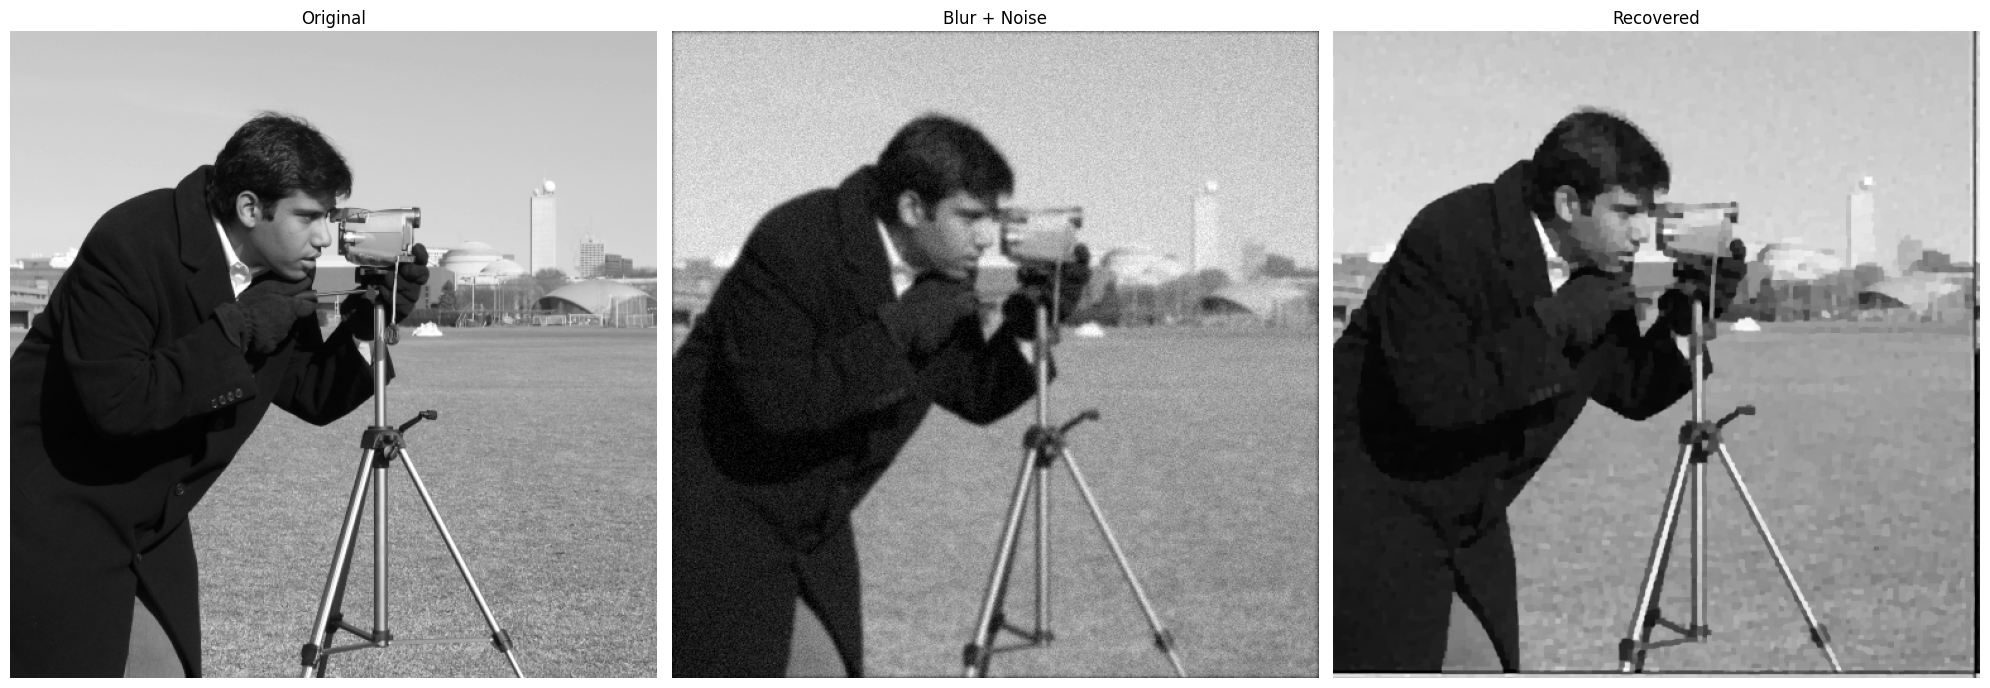

In [18]:
H, W = img.shape
plt.figure(figsize=(20, int(20*H/W)))

plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(blurry_noisy, cmap='gray')
plt.title('Blur + Noise')
plt.axis('off')

plt.subplot(133)
plt.imshow(x, cmap='gray')
plt.title(f'Recovered')
plt.axis('off')

plt.tight_layout()
plt.show()

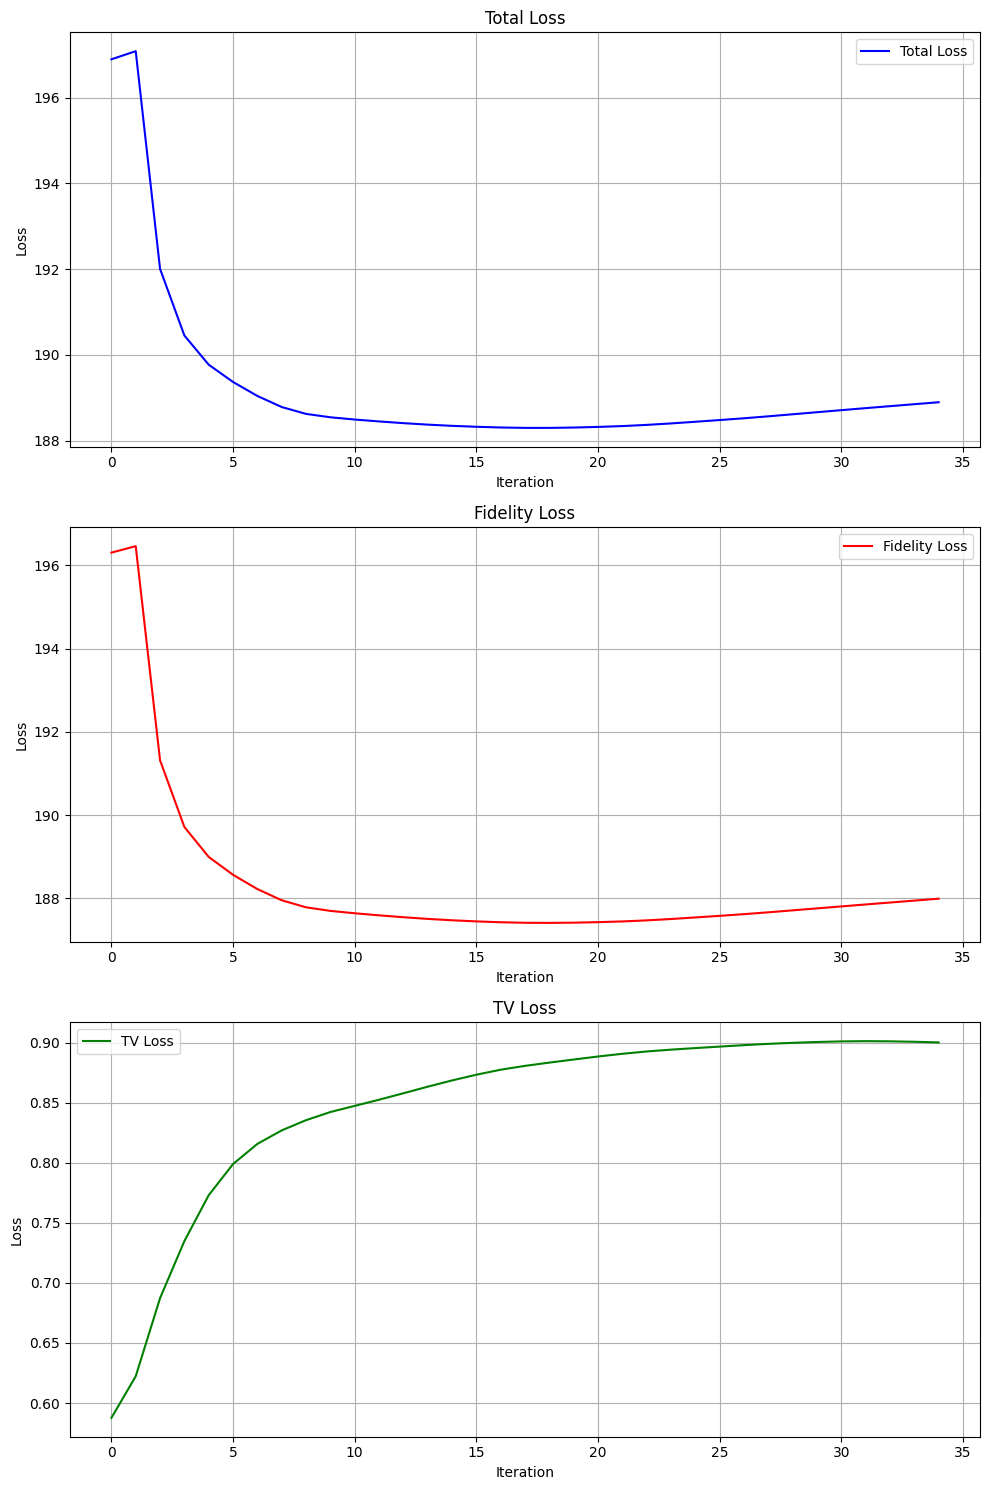

In [15]:
losses = DeconvSolver.losses

total_losses = losses['total']
fidelity_losses = losses['fidelity']
TV_losses = losses['TV']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

ax1.plot(total_losses, 'b-', label='Total Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Total Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(fidelity_losses, 'r-', label='Fidelity Loss')
ax2.set_xlabel('Iteration') 
ax2.set_ylabel('Fidelity Loss')
ax2.legend()
ax2.grid(True)

ax3.plot(TV_losses, 'g-', label='TV Loss')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('TV Loss')
ax3.legend()
ax3.grid(True)


plt.tight_layout()
plt.show()


## Color:

In [11]:
from skimage.data import camera, astronaut

img = astronaut() / 255.0
# img = cv2.imread('../data/pittsburgh.webp') / 255.0

# psf = get_gaussian_psf(k_size=25, std=8)
# psf = get_box_psf(k_size=9)
# psf = get_circle_psf(k_size=9)

blurry_img = np.zeros_like(img)
for c in range(3):
    blurry_img[:,:,c] = scipy.signal.convolve2d(img[:,:,c], psf, mode='same')
noise = 0.04 * np.random.randn(img.shape[0], img.shape[1], img.shape[2])
blurry_noisy = np.clip(blurry_img + noise, 0, 1)

In [12]:
deblurred_img = np.zeros_like(img)

for c in range(3): # independent per-channel deconvolution
    lmda = 0.0075
    rho = 0.2
    DeconvSolver = ADMMTVSolver(blurry_noisy[:,:,c], psf, lmda, rho, log=True)
    n_iters = 35
    x_c = DeconvSolver.solve(n_iters)
    deblurred_img[:,:,c] = x_c

    if c == 0:
        R_losses = DeconvSolver.losses
        R_xs = DeconvSolver.xs
    elif c == 1:
        G_losses = DeconvSolver.losses
        G_xs = DeconvSolver.xs
    else:
        B_losses = DeconvSolver.losses
        B_xs = DeconvSolver.xs

100%|██████████| 35/35 [00:01<00:00, 20.57it/s]


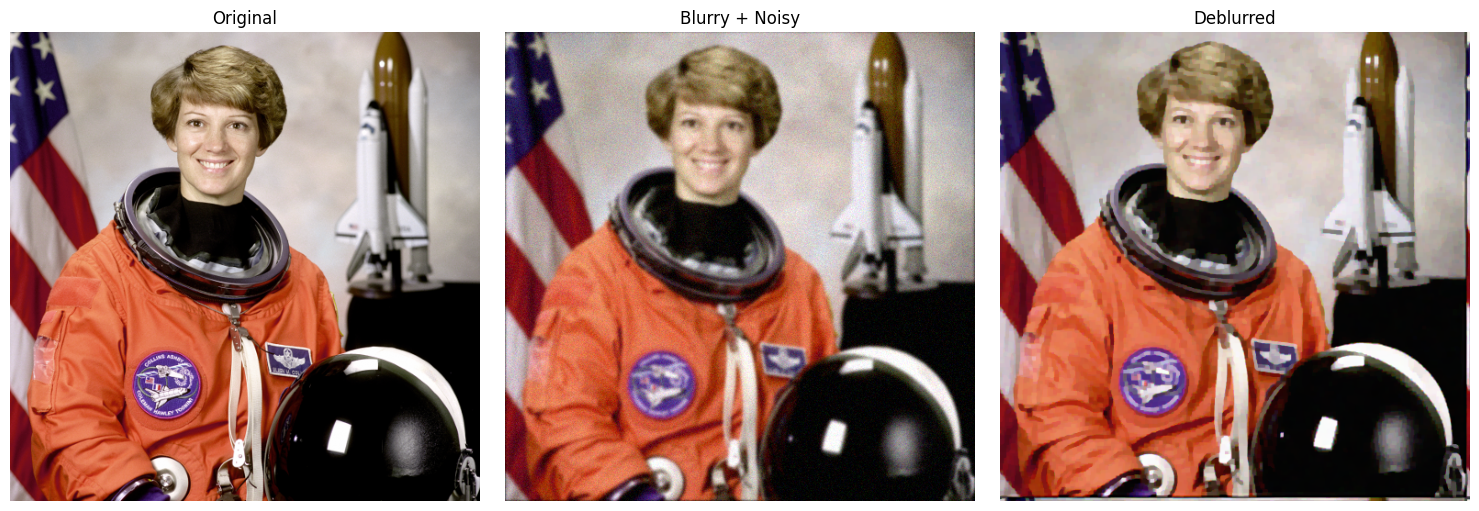

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(blurry_noisy)
axes[1].set_title('Blurry + Noisy')
axes[1].axis('off')

axes[2].imshow(deblurred_img)
axes[2].set_title('Deblurred')
axes[2].axis('off')

plt.tight_layout()
plt.show()

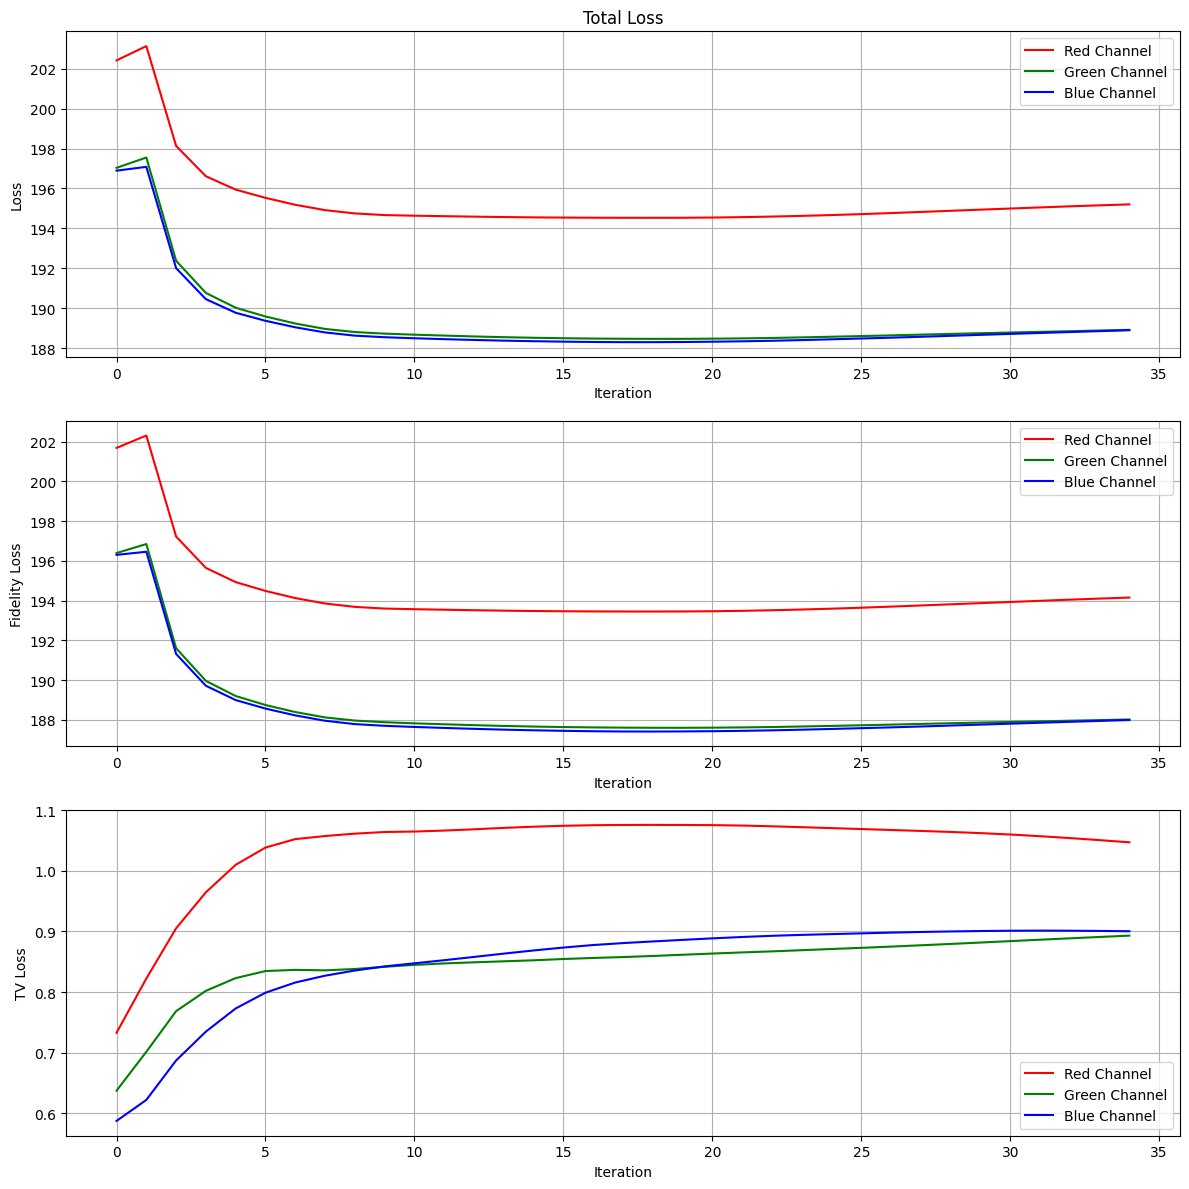

In [14]:
# Get losses for each color channel
R_total_losses = R_losses['total']
R_fidelity_losses = R_losses['fidelity']
R_TV_losses = R_losses['TV']

G_total_losses = G_losses['total']
G_fidelity_losses = G_losses['fidelity']
G_TV_losses = G_losses['TV']

B_total_losses = B_losses['total']
B_fidelity_losses = B_losses['fidelity']
B_TV_losses = B_losses['TV']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

ax1.plot(R_total_losses, 'r-', label='Red Channel')
ax1.plot(G_total_losses, 'g-', label='Green Channel')
ax1.plot(B_total_losses, 'b-', label='Blue Channel')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Total Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(R_fidelity_losses, 'r-', label='Red Channel')
ax2.plot(G_fidelity_losses, 'g-', label='Green Channel')
ax2.plot(B_fidelity_losses, 'b-', label='Blue Channel')
ax2.set_xlabel('Iteration') 
ax2.set_ylabel('Fidelity Loss')
ax2.legend()
ax2.grid(True)

ax3.plot(R_TV_losses, 'r-', label='Red Channel')
ax3.plot(G_TV_losses, 'g-', label='Green Channel')
ax3.plot(B_TV_losses, 'b-', label='Blue Channel')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('TV Loss') 
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()
